# Introduction to A/B Testing in R

We want to analyze a fictional dataset spanning seven months from July to January, where we conducted an A/B test in October. 

The dataset is a fictional dataset which has been created in *data_creation.ipynb*

In [1]:
library(tidyverse)
# Not directly available from Workspace, locally you should be able to use install.packages("lmtest") and install.packages("sandwich")
install.packages("lmtest_0.9-40.tar.gz", repos = NULL, type = "source")
install.packages("sandwich_3.0-2.tar.gz", repos = NULL, type = "source")
#
library(lmtest)
library(sandwich)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into ‘/home/repl/renv/library/R-4.2/x86_64-pc-linux-gnu’
(as ‘lib’ is unspecified)

Installing package into ‘/home/repl/renv/library/R-4.2/x86_64-pc-linux-gnu’
(as ‘lib’ is unspecified)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Tasks 1

Load the **experiment_data.csv** via `read_csv` and look at some random rows.

`Month` shows the time dimension ranging from July 2022 to January 2023. 

`Group` indicates whether a customer is in the treatment group or not

`Treated` is always 0 for the control (*Existing*) group as well as for the A group before October (prior to implementing the experiment). 

`Dollars` are the $ spent by our customers 

`id` is a personal identifier of the customers



In [2]:
# load the experiment_data.csv and look at 10 random rows
customer_data = read_csv("experiment_data.csv") 
customer_data[sample(1:nrow(customer_data), size = 15),]

Rows: 1500 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Group
dbl (4): Month, Treated, Dollars, id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Month,Group,Treated,Dollars,id
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
202210,Existing,0.0,60.57,292
202208,Existing,0.0,37.16,323
202211,New,1.0,89.93,163
202301,New,1.0,41.67,23
202212,Existing,0.0,63.43,339
202212,New,1.0,58.21,70
202210,New,0.5,70.70,57
202209,New,0.0,48.97,113
202208,New,0.0,32.93,11


## Task 2

Look at the customer_data to see the number of customers we observe per month in each group. How many individual customers are there? 
Look at the `Treated` column by `Month`

In [3]:
cat("Rows and unique rows in the dataset:\n")
nrow(customer_data)
nrow(distinct(customer_data))
cat("\nUnique/distinct months in the dataset:\n")
table(customer_data$Month)
cat("\nUnique/distinct customers in the dataset:\n")
nrow(distinct(customer_data, id))

cat("\nNumber of clients by group ('New' vs 'Existing'):\n")
table(customer_data$Group) 
cat("\n")
table(customer_data$Month, customer_data$Treated)

Rows and unique rows in the dataset:


[1] 1500

[1] 1500


Unique/distinct months in the dataset:



202207 202208 202209 202210 202211 202212 202301 
   205    211    207    207    214    230    226 


Unique/distinct customers in the dataset:


[1] 398


Number of clients by group ('New' vs 'Existing'):



Existing      New 
     791      709 

        
           0 0.5   1
  202207 205   0   0
  202208 211   0   0
  202209 207   0   0
  202210 112  95   0
  202211 109   0 105
  202212 120   0 110
  202301 123   0 103

## Task 3 

Aggregate the whole dataset by `Month` and `Group` and look at the `Dollars` spent with a line plot. 

In [4]:
month_group_data <- customer_data %>% group_by(Month, Group) %>% summarise(Dollars = mean(Dollars), Treatment = mean(Treated))
month_group_data %>% arrange(Month, Group)

`summarise()` has grouped output by 'Month'. You can override using the
`.groups` argument.
New names:
• `` -> `...1`


Month,Group,Dollars,Treatment
<dbl>,<chr>,<dbl>,<dbl>
202207,Existing,52.34873,0.0
202207,New,47.11758,0.0
202208,Existing,49.44972,0.0
202208,New,47.79670,0.0
202209,Existing,48.44917,0.0
202209,New,49.57878,0.0
202210,Existing,46.25839,0.0
202210,New,49.84221,0.5
202211,Existing,49.05615,0.0


In [5]:
month_group_data

New names:
• `` -> `...1`


Month,Group,Dollars,Treatment
<dbl>,<chr>,<dbl>,<dbl>
202207,Existing,52.34873,0.0
202207,New,47.11758,0.0
202208,Existing,49.44972,0.0
202208,New,47.79670,0.0
202209,Existing,48.44917,0.0
202209,New,49.57878,0.0
202210,Existing,46.25839,0.0
202210,New,49.84221,0.5
202211,Existing,49.05615,0.0


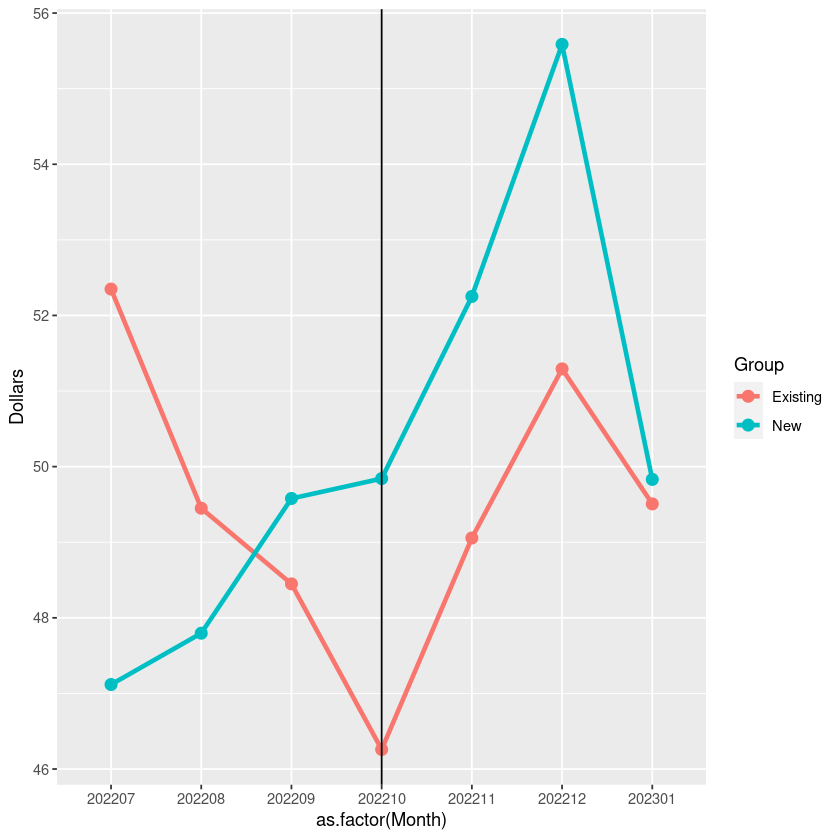

In [6]:
time_series_plot <- ggplot(month_group_data, 
						  aes(x = as.factor(Month),
							 y = Dollars,
							 color = Group,
							 group = Group)) + geom_point(size = 3)+ geom_line(linewidth = 1.3) + geom_vline(xintercept = 4)
time_series_plot

In [7]:
# Drop October (because some in the 'New' group already saw the new product others still the old one)
customer_data <- customer_data %>% filter(Month != "202210")
# Add a binary to indicate the actual A/B testing period
customer_data$AB_period <- ifelse(customer_data$Month %in% c('202211', '202212', '202301'), 1, 0)
# show the result
table(customer_data$Month, customer_data$AB_period)

        
           0   1
  202207 205   0
  202208 211   0
  202209 207   0
  202211   0 214
  202212   0 230
  202301   0 226

## Task 4

Plot the `Dollars` spent by `Group` in the actual A/B time period. 

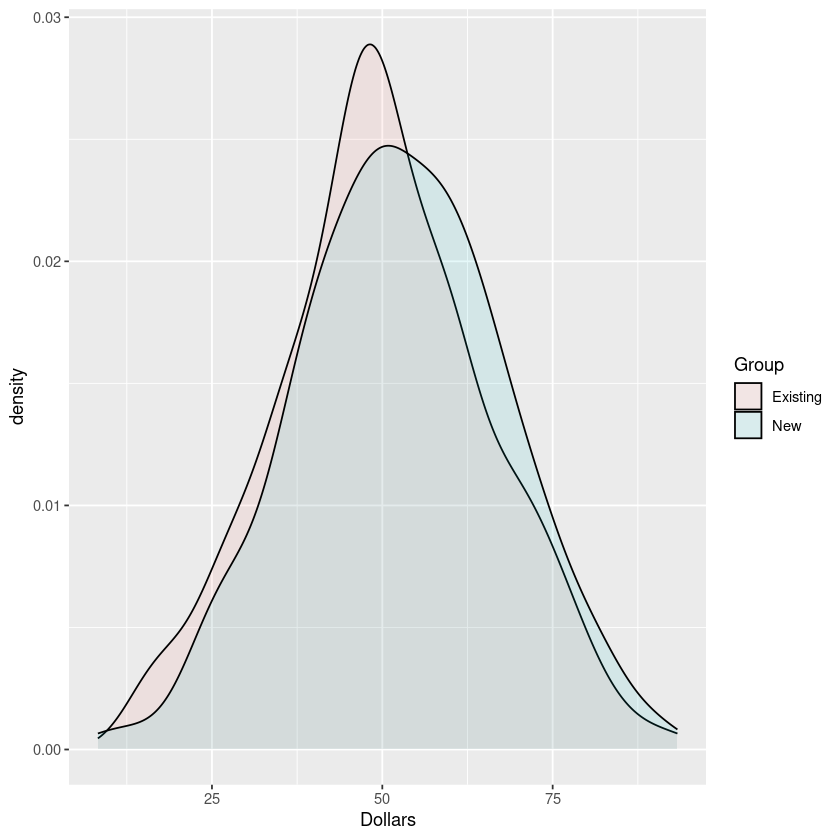

In [8]:
ggplot(customer_data %>% filter(AB_period == 1), aes(Dollars, fill = Group)) + geom_density(alpha = 0.1)

## Task 5 

Plot again the `Dollars` spent by `Group` in the actual A/B time period. This time, however, on a new dataset where we averaged the individual Dollars spent (by period) to avoid having multiple observations by the same customer during the same period. 

In [9]:
# get the column names from dataset
colnames(customer_data)

[1] "Month"     "Group"     "Treated"   "Dollars"   "id"        "AB_period"

In [10]:
# Now aggregate on the customer-level that we get one row for each customer before and after seeing the "New" product
customer_data_aggregated <- customer_data %>% group_by(id, Group, Treated, AB_period) %>% summarise(Dollars = mean(Dollars))
customer_data_aggregated <- customer_data_aggregated %>% arrange(id, Group, AB_period)
head(customer_data_aggregated)
tail(customer_data_aggregated)

`summarise()` has grouped output by 'id', 'Group', 'Treated'. You can override
using the `.groups` argument.
New names:
• `` -> `...1`


id,Group,Treated,AB_period,Dollars
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,New,0,0,44.12000
1,New,1,1,56.93667
2,New,0,0,61.12000
2,New,1,1,48.73667
3,New,0,0,65.37000
3,New,1,1,53.48500


New names:
• `` -> `...1`


id,Group,Treated,AB_period,Dollars
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
397,Existing,0,1,49.450
398,Existing,0,1,35.970
399,Existing,0,0,61.270
399,Existing,0,1,30.015
400,Existing,0,0,41.920
400,Existing,0,1,42.480


## Task 6

Now let's compare the `Dollars` spent between `New` vs. `Existing` `Group` in the actual A/B testing period.

In [11]:
# applying t-test to compare them

t.test( 
	customer_data_aggregated %>% filter(Group == 'New', AB_period == 1) %>% pull(Dollars),
	customer_data_aggregated %>% filter(Group == 'Existing', AB_period == 1) %>% pull(Dollars)
)


	Welch Two Sample t-test

data:  customer_data_aggregated %>% filter(Group == "New", AB_period == 1) %>% pull(Dollars) and customer_data_aggregated %>% filter(Group == "Existing", AB_period == 1) %>% pull(Dollars)
t = 1.6855, df = 368, p-value = 0.09274
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3656609  4.7530882
sample estimates:
mean of x mean of y 
 52.42986  50.23615 


## Task 7

But we could also compare only `New` before and after implementing the A/B test. Let's do that!! 

In [12]:
t.test(
	customer_data_aggregated %>% filter(Group == 'New', AB_period == 1) %>% pull(Dollars),
	customer_data_aggregated %>% filter(Group == 'New', AB_period == 0) %>% pull(Dollars)
)


	Welch Two Sample t-test

data:  customer_data_aggregated %>% filter(Group == "New", AB_period == 1) %>% pull(Dollars) and customer_data_aggregated %>% filter(Group == "New", AB_period == 0) %>% pull(Dollars)
t = 3.268, df = 350.19, p-value = 0.00119
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.818671 7.316318
sample estimates:
mean of x mean of y 
 52.42986  47.86237 


## Task 8 

Calculate the standard deviation of the `Dollars` spent in A/B period of the `New` group and use `power.t.test()` to calculate the necessary sample size to get statistical significant results on the `p = 0.05` signficiance level assuming `power = 0.8` (and equal variances). 

In [13]:
sd = round(sd(customer_data_aggregated %>% filter(Group == "New" & AB_period == 1) %>% pull(Dollars)), 1)
# power test
power.t.test(delta = 2.2, sd = sd, power = 0.8, sig.level = 0.05)


     Two-sample t test power calculation 

              n = 499.6579
          delta = 2.2
             sd = 12.4
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


## Task 9

Finally, let's run a linear regression approach where we regress `Treated`, `Group`, `as.factor(Month)` on `Dollars`.
Let's correct the standard error for the fact that we observe some clients multiple times. 

In [14]:
colnames(customer_data_aggregated)

[1] "id"        "Group"     "Treated"   "AB_period" "Dollars"

In [23]:
# multiple linear regression on actual dataset
library(lmtest)
library(sandwich)

model <- lm(Dollars ~ Treated + Group + as.factor(Month), data = customer_data)
coeftest(model, vcov = vcovCL(model, cluster = customer_data$id))


t test of coefficients:

                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            50.80636    1.25943 40.3407  < 2e-16 ***
Treated                 4.51114    1.76617  2.5542  0.01076 *  
GroupNew               -1.90288    1.25675 -1.5141  0.13024    
as.factor(Month)202208 -1.23467    1.48177 -0.8332  0.40486    
as.factor(Month)202209 -0.92152    1.58343 -0.5820  0.56068    
as.factor(Month)202211 -1.46228    1.81296 -0.8066  0.42006    
as.factor(Month)202212  1.29234    1.82164  0.7094  0.47818    
as.factor(Month)202301 -2.34026    1.76984 -1.3223  0.18631    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


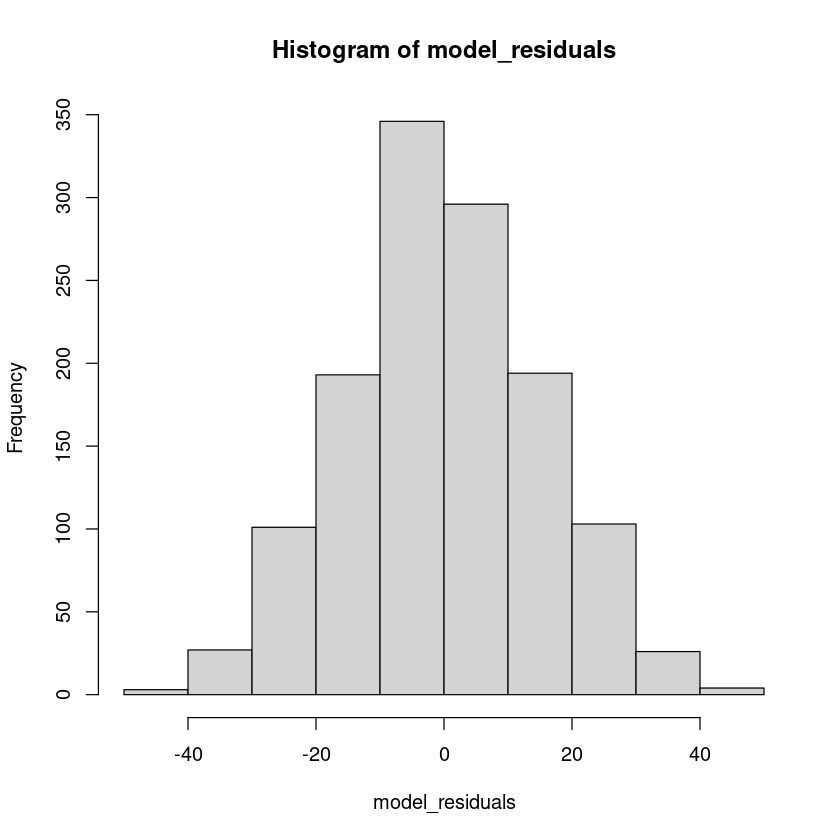

In [16]:
# get model residuals and plot a histogram of that residuals
model_residuals <- model$residuals
# ploting a histograms
hist(model_residuals)

## The plotted histogram is normally distributed. Let's recheck the normal distribution with Q-plot. If the plot is similar to a straight line, we will be confident enough that the model is normally distributed. 

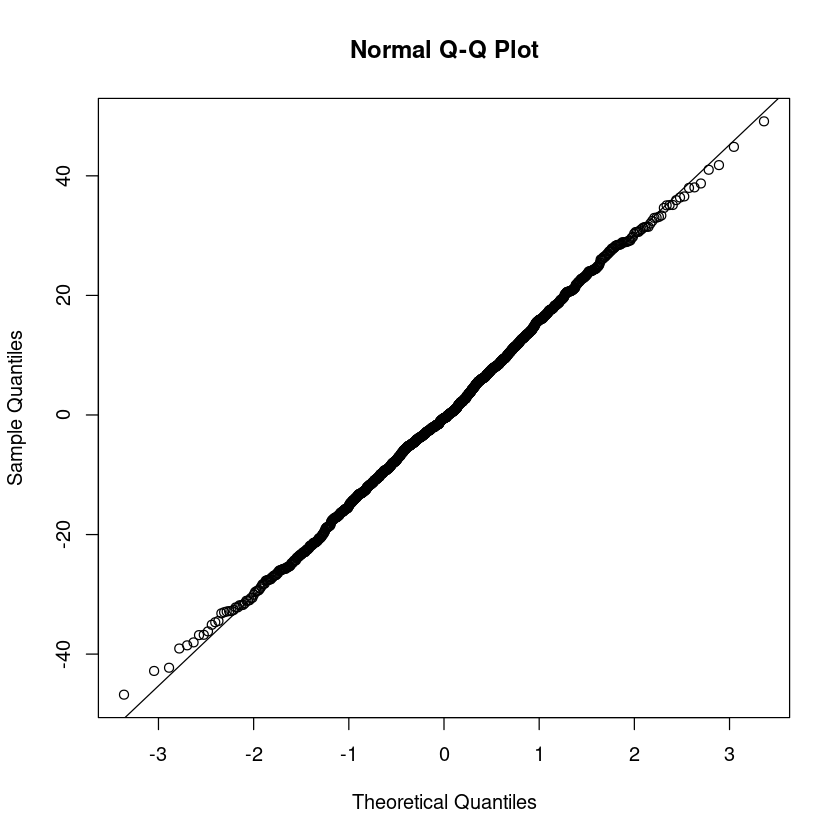

In [17]:
# plot the residuals QQ-plot
qqnorm(model_residual)
# plot the QQ-line
qqline(model_residuals)

## The model's residuals is normally distributed. 

**Another way of looking at the important variables in the model is through a significance test.** 

**A variable will be significant if its p-value is less than 0.05. This result can be generated by the `summary()` function. In addition to providing that information about the model it also renders the adjusted R-square, which evaluates the performance of models against each other.**

In [22]:
# summary of customer_data
summary(model)


Call:
lm(formula = Dollars ~ Treated + Group + as.factor(Month), data = customer_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.782 -10.226  -0.544  10.124  49.115 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             50.8064     1.2046  42.178  < 2e-16 ***
Treated                  4.5111     1.6973   2.658  0.00796 ** 
GroupNew                -1.9029     1.2216  -1.558  0.11955    
as.factor(Month)202208  -1.2347     1.4933  -0.827  0.40849    
as.factor(Month)202209  -0.9215     1.5001  -0.614  0.53912    
as.factor(Month)202211  -1.4623     1.6936  -0.863  0.38806    
as.factor(Month)202212   1.2923     1.6662   0.776  0.43811    
as.factor(Month)202301  -2.3403     1.6628  -1.407  0.15954    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.22 on 1285 degrees of freedom
Multiple R-squared:  0.01622,	Adjusted R-squared:  0.01086 
F-statistic: 3.027 on 7 and 1285 DF,  p-v

## Applying multiple linear regression on `customer_data_aggregated` dataset
**It's filtered on the actual AB_period**

In [24]:
colnames(customer_data_aggregated)

[1] "id"        "Group"     "Treated"   "AB_period" "Dollars"

In [25]:
## applying multiple linear regression
agg_model <- lm(Dollars ~ Treated + AB_period + Group, data = customer_data_aggregated)
coeftest(agg_model, vcov = vcovCL(agg_model, cluster = customer_data_aggregated$id))


t test of coefficients:

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 50.89623    0.89767 56.6980 < 2.2e-16 ***
Treated      5.22757    1.90489  2.7443  0.006213 ** 
AB_period   -0.66008    1.33429 -0.4947  0.620957    
GroupNew    -3.03386    1.38742 -2.1867  0.029081 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


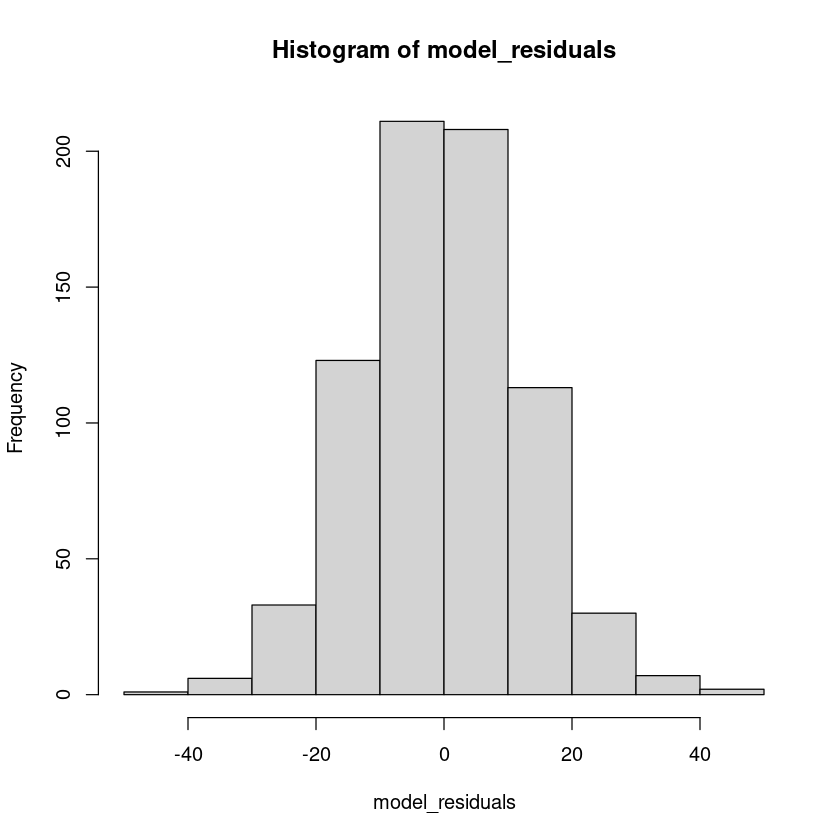

In [26]:
# get model residuals and plot a histogram of that residuals
model_residuals <- agg_model$residuals
# ploting a histograms
hist(model_residuals)

### The plotted histogram is normally distributed. Let's recheck the normal distribution with Q-plot. If the plot is similar to a straight line, we will be confident enough that the model is normally distributed.

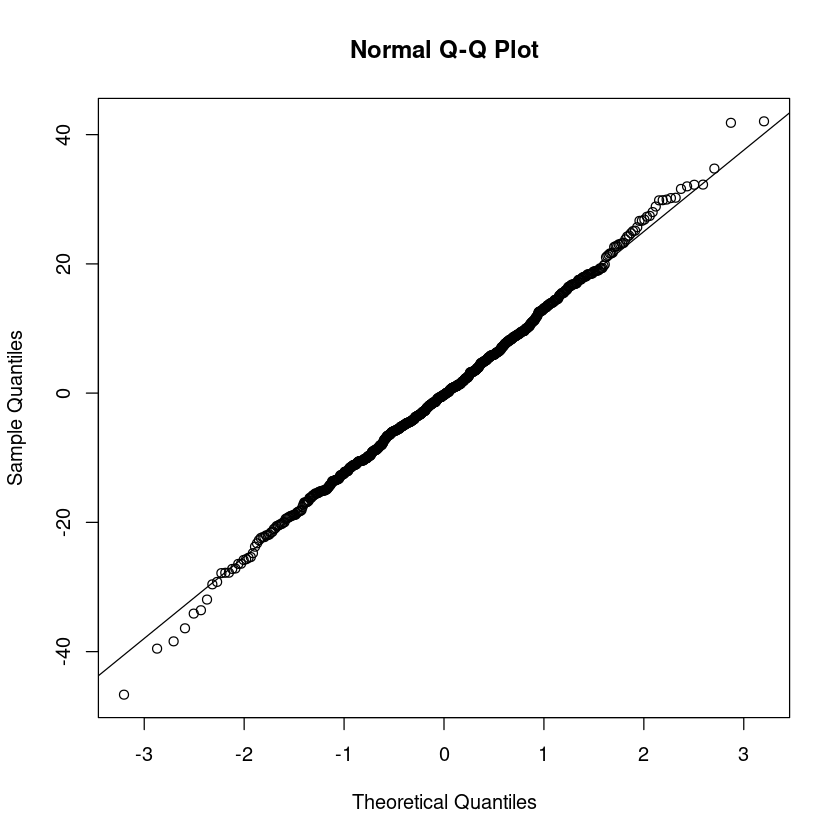

In [28]:
# plot the residuals QQ-plot
qqnorm(model_residuals)
# plot the QQ-line
qqline(model_residuals)

### The model's residuals is normally distributed.


**Another way of looking at the important variables in the model is through a significance test.**

**A variable will be significant if its p-value is less than 0.05. This result can be generated by the `summary()` function. In addition to providing that information about the model it also renders the adjusted R-square, which evaluates the performance of models against each other.**

In [29]:
# summary of agg_model
summary(agg_model)


Call:
lm(formula = Dollars ~ Treated + AB_period + Group, data = customer_data_aggregated)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.662  -8.671  -0.284   8.316  42.058 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  50.8962     0.9425  54.003  < 2e-16 ***
Treated       5.2276     1.8981   2.754  0.00603 ** 
AB_period    -0.6601     1.3311  -0.496  0.62011    
GroupNew     -3.0339     1.3477  -2.251  0.02468 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.85 on 730 degrees of freedom
Multiple R-squared:  0.01592,	Adjusted R-squared:  0.01187 
F-statistic: 3.936 on 3 and 730 DF,  p-value: 0.008405


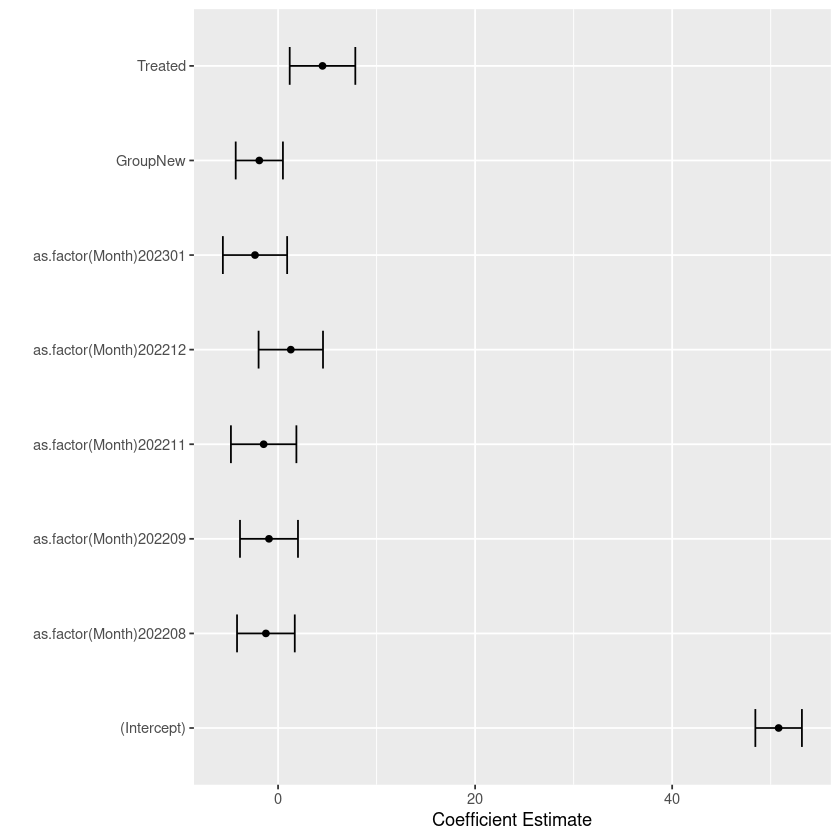

In [18]:
# Load necessary libraries
library(ggplot2)
library(tidyr)

# Extract coefficient estimates and standard errors
coef_df <- broom::tidy(model, conf.int = TRUE)

# Plot coefficient estimates and confidence intervals
ggplot(coef_df, aes(x = term, y = estimate, ymin = conf.low, ymax = conf.high)) +
  geom_point() +
  geom_errorbar(width = 0.4) +
  coord_flip() +
  xlab("") +
  ylab("Coefficient Estimate")


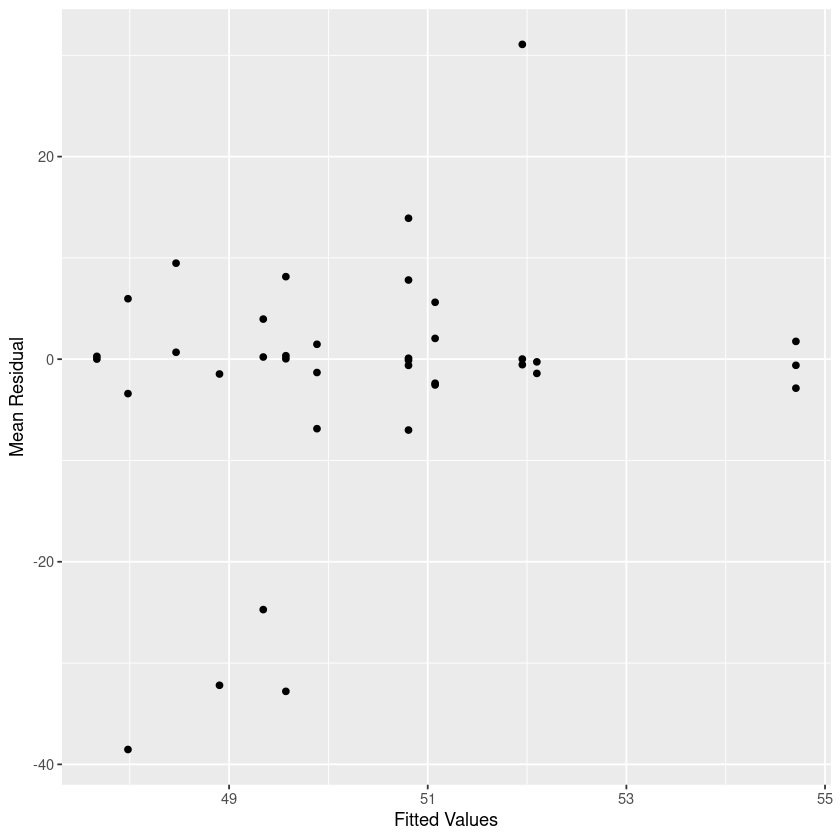

In [19]:
# Extract residuals
resid_df <- data.frame(residuals = model$residuals, 
                       fitted.values = model$fitted.values, 
                       Client_ID = customer_data$id)

# Compute mean residual by fitted value
resid_df <- resid_df %>% 
  group_by(fitted.values) %>% 
  summarise(mean_residual = mean(residuals))

# Plot mean residual by fitted value
ggplot(resid_df, aes(x = fitted.values, y = mean_residual)) +
  geom_point() +
  xlab("Fitted Values") +
  ylab("Mean Residual")
